In [ ]:
from keras.datasets import mnist
from keras.models import Sequential
from keras.layers import Dense
from keras.callbacks import LambdaCallback
from keras import backend as K
from keras import activations
import keras
import numpy as np
from keras.datasets import mnist
from keras.utils import to_categorical
from keras.callbacks import Callback
from scipy.stats import pearsonr, spearmanr
from google.colab import drive
import matplotlib.pyplot as plt
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Load arrays from Google Drive
X_train = np.load('/content/drive/My Drive/X_train_new.npy')
y_train = np.load('/content/drive/My Drive/y_train_new.npy')
X_test = np.load('/content/drive/My Drive/X_test_new.npy')
y_test = np.load('/content/drive/My Drive/y_test_new.npy')

In [ ]:
model = Sequential()
model.add(Dense(128, activation='relu', input_shape=(784,)))
model.add(Dense(128, activation='relu', input_shape=(128,)))
model.add(Dense(11, activation='softmax'))

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [ ]:
ratio = 1
ds_size = len(X_train)  * ratio
batchsize_train = 128
dense_size = 128
n_batches = int(ds_size // batchsize_train)
n_epochs = 3
n_layers = 2

In [ ]:
shapes = (n_batches, batchsize_train, dense_size)
layer_activations = []
for _ in range(n_layers):
  epochs = []
  for i in range(n_epochs):
    epochs.append(np.empty(shapes))
  layer_activations.append(epochs)
model_output = []
weights = []

class CustomCallback(Callback):
    def __init__(self):
        super(CustomCallback, self).__init__()
        for i in range(n_layers):
          model_output.append(model.layers[i].output)
        self.ok = False #used for testing

    def on_epoch_begin(self, epoch, logs=None):
      self.neuron_activations = []
      for i in range(n_layers):
        self.neuron_activations.append(layer_activations[i][epoch])
      if epoch == 0: ## replace 0 with the epoch you wanna test
        self.ok = True

    def on_batch_begin(self, batch, logs=None):
        get_activations = K.function([model.layers[0].input], model_output)
        if batch != (n_batches):  # we ignore the last, uncompleted batch so we can have a matrix
          get_act = get_activations([X_train[(batch) * batchsize_train: (batch + 1) * batchsize_train]])
          for i in range(n_layers):
            activations = get_act[i]
            self.neuron_activations[i][batch]= np.array(activations)


custom_callback = CustomCallback()

model.fit(X_train, y_train, epochs=n_epochs, batch_size=batchsize_train, callbacks=[custom_callback])


Epoch 1/3
  5/516 [..............................] - ETA: 7s - loss: 2.1828 - accuracy: 0.2891  

516/516 [==============================] - 8s 14ms/step - loss: 0.2831 - accuracy: 0.9190
Epoch 2/3
516/516 [==============================] - 8s 16ms/step - loss: 0.1125 - accuracy: 0.9663
Epoch 3/3
516/516 [==============================] - 7s 14ms/step - loss: 0.0783 - accuracy: 0.9757


Properly arrange list

In [ ]:
neuron_activations = []
for j in range(n_layers):
  for i in range(n_epochs):
    layer_activations[j][i] = np.reshape(layer_activations[j][i], (n_batches * batchsize_train, dense_size ))
    layer_activations[j][i] = layer_activations[j][i].T.reshape((dense_size,-1))
  neuron_activations.append(np.hstack(layer_activations[j]))


We now compute the ranges of the neurons

In [ ]:
x_std = 1.5

In [ ]:
neurons_mstd = np.empty((n_layers, dense_size, 2))
for layer_ in range(n_layers):
  for neuron_ in range(dense_size):
     mean = np.mean(neuron_activations[layer_][neuron_])
     std = np.std(neuron_activations[layer_][neuron_])
     neurons_mstd[layer_][neuron_][0] = mean - x_std * std
     neurons_mstd[layer_][neuron_][1] = mean + x_std * std

In [ ]:
ranges = neurons_mstd

Create random list to get out of range

In [ ]:
random_X_test = np.random.choice([-1., 1.], size=(11000, 784), p=[0.5, 0.5])
random_X_test += np.random.rand(11000, 784)  # Add random values between 0 and 1

Get activations from tests and random tests

In [ ]:
get_testing_a = K.function([model.layers[0].input],
                                  model_output)
get_label_pred = K.function([model.layers[0].input],
                                  [model.layers[-1].output])
layers_output_random = get_testing_a([random_X_test])
label_pred_random = get_label_pred([random_X_test])[0]

In [ ]:

max_indices = np.argmax(label_pred_random, axis=1) # having the right label eg 7 or 4
y_test_predict_random = np.zeros((max_indices.size, 11))
y_test_predict_random[np.arange(max_indices.size), max_indices] = 1 # one hot encoded

Find correlation

In [ ]:
def find_corr(array_v, array_bool):
  numeric_boolean_values = array_bool.astype(int)
  pearson_corr, pearson_p_value = pearsonr(array_v, numeric_boolean_values)
  spearman_corr, spearman_p_value = spearmanr(array_v, numeric_boolean_values)
  return pearson_corr,pearson_p_value, spearman_corr,spearman_p_value

Rearrange the list properly

In [ ]:
layers_output_random = np.array(layers_output_random)
layers_output_random = layers_output_random.transpose(0, 2, 1)

In [ ]:
n_images = len(layers_output_random[0][0])
percentages = np.empty(n_images)
for i in range(n_images):
  count = 0
  for layer in range(n_layers):
    for neuron in range(dense_size):
        if ranges[layer][neuron][0] <= layers_output_random[layer][neuron][i] <= ranges[layer][neuron][1] :
          count +=1
  percentages[i] = count / (n_layers * dense_size) * 100

In [ ]:
a = np.array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.])

Check which predictions are right for the NonImage input

In [ ]:
c = 0
for element in y_test_predict_random:
  if np.array_equal(element,a):
    c += 1
print(c)

9812


In [ ]:
a = np.array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.])


In [ ]:
correct_answers = np.tile(a, (11000, 1))


In [ ]:
result_rand = np.equal(correct_answers, y_test_predict_random)

result_rand = result_rand.all(axis=1)

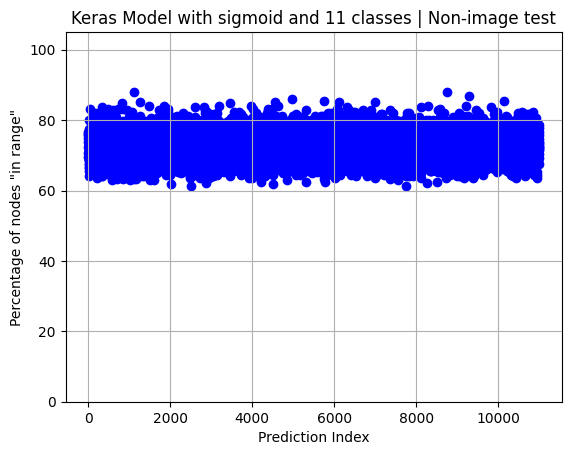

In [ ]:
plt.scatter(np.arange(len(percentages)), percentages, color='blue', marker='o')
plt.title('Keras Model with sigmoid and 11 classes | Non-image test')
plt.xlabel('Prediction Index')
plt.ylabel('Percentage of nodes "in range"')
plt.grid(True)
plt.ylim(0, 105)
plt.show()

In [ ]:
acc_count_rand= [[0,0],[0,0],[0,0],[0,0],[0,0],[0,0],[0,0],[0,0]]
for i in range(len(percentages)):
  a = percentages[i]
  if 80. <= a < 85. :
    acc_count_rand[0][0] += 1
    if result_rand[i]:
      acc_count_rand[0][1] += 1
  if 85. <= a < 90. :
    acc_count_rand[1][0] += 1
    if result_rand[i] :
      acc_count_rand[1][1] += 1
  if 90. <= a < 95.:
    acc_count_rand[2][0] += 1
    if result_rand[i] :
      acc_count_rand[2][1] += 1
  if 95. <= a :
    acc_count_rand[3][0] += 1
    if result_rand[i]:
      acc_count_rand[3][1] += 1
  if 75. <= a < 80. :
    acc_count_rand[4][0] += 1
    if result_rand[i] :
      acc_count_rand[4][1] += 1
  if 70. <= a < 75. :
    acc_count_rand[5][0] += 1
    if result_rand[i] :
      acc_count_rand[5][1] += 1
  if 65. <= a < 70. :
    acc_count_rand[6][0] += 1
    if result_rand[i] :
      acc_count_rand[6][1] += 1
  if 60. <= a < 65. :
    acc_count_rand[7][0] += 1
    if result_rand[i] :
      acc_count_rand[7][1] += 1

In [ ]:
a,b,c,d = find_corr(percentages, result_rand)

In [ ]:
print(f'Accuracy if percentage is between 60 and 65:{acc_count_rand[7][1]/acc_count_rand[7][0]}')
print(f'Accuracy if percentage is between 65 and 70:{acc_count_rand[6][1]/acc_count_rand[6][0]}')
print(f'Accuracy if percentage is between 70 and 75:{acc_count_rand[5][1]/acc_count_rand[5][0]}')
print(f'Accuracy if percentage is between 75 and 80:{acc_count_rand[4][1]/acc_count_rand[4][0]}')
print(f'Accuracy if percentage is between 80 and 85:{acc_count_rand[0][1]/acc_count_rand[0][0]}')
# print(f'Accuracy if percentage is between 85 and 90:{acc_count_rand[1][1]/acc_count_rand[1][0]}')
# print(f'Accuracy if percentage is between 90 and 95:{acc_count_rand[2][1]/acc_count_rand[2][0]}')
# print(f'Accuracy if percentage is between 95 and 100:{acc_count_rand[3][1]/acc_count_rand[3][0]}')
print(f'Pearson correlation: {a} and p-value:{b}')
print(f'Spearman correlation: {c} and p-value:{d}')

Accuracy if percentage is between 60 and 65:0.8613138686131386
Accuracy if percentage is between 65 and 70:0.9081999346618752
Accuracy if percentage is between 70 and 75:0.8937784522003035
Accuracy if percentage is between 75 and 80:0.8785620341955283
Accuracy if percentage is between 80 and 85:0.8075313807531381
Pearson correlation: -0.056450081139005785 and p-value:3.13085315270183e-09
Spearman correlation: -0.05247412944283438 and p-value:3.6561944182598435e-08


Now we check the Image input

In [ ]:
layers_output = get_testing_a([X_test])
label_pred = get_label_pred([X_test])[0]

In [ ]:
max_indices = np.argmax(label_pred, axis=1) # having the right label eg 7 or 4
y_test_predict = np.zeros((max_indices.size, 11))
y_test_predict[np.arange(max_indices.size), max_indices] = 1 # one hot encoded

In [ ]:
layers_output= np.array(layers_output)
layers_output = layers_output.transpose(0, 2, 1)

In [ ]:
n_images = len(layers_output[0][0])
percentages = np.empty(n_images)
for i in range(n_images):
  count = 0
  for layer in range(n_layers):
    for neuron in range(dense_size):
        if ranges[layer][neuron][0] <= layers_output[layer][neuron][i] <= ranges[layer][neuron][1] :
          count +=1
  percentages[i] = count / (n_layers * dense_size) * 100

In [ ]:
k = 0
for element in y_test_predict_random:
  if np.array_equal(element,a):
    k += 1
print(k)

0


In [ ]:
equality_list = np.equal(y_test_predict, y_test).all(axis=1)

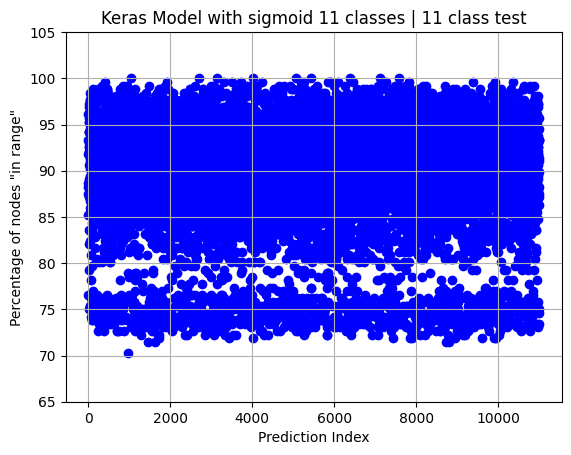

In [ ]:
plt.scatter(np.arange(len(percentages)), percentages, color='blue', marker='o')
plt.title('Keras Model with sigmoid 11 classes | 11 class test')
plt.xlabel('Prediction Index')
plt.ylabel('Percentage of nodes "in range"')
plt.grid(True)
plt.ylim(65, 105)
plt.show()

In [ ]:
result = np.equal(y_test, y_test_predict)

result = result.all(axis=1)

In [ ]:
acc_count = [[0,0],[0,0],[0,0],[0,0],[0,0],[0,0]]
for i in range(len(percentages)):
  a = percentages[i]
  if 80. <= a < 85. :
    acc_count[0][0] += 1
    if result[i]:
      acc_count[0][1] += 1
  if 85. <= a < 90. :
    acc_count[1][0] += 1
    if result[i] :
      acc_count[1][1] += 1
  if 90. <= a < 95.:
    acc_count[2][0] += 1
    if result[i] :
      acc_count[2][1] += 1
  if 95. <= a :
    acc_count[3][0] += 1
    if result[i]:
      acc_count[3][1] += 1
  if 75. <= a < 80. :
    acc_count[4][0] += 1
    if result[i] :
      acc_count[4][1] += 1
  if 70. <= a < 75. :
    acc_count[5][0] += 1
    if result[i] :
      acc_count[5][1] += 1

In [ ]:
a,b,c,d = find_corr(percentages,result)

In [ ]:
np.sum(result)/len(result)

0.9697272727272728

In [ ]:
# print(f'Accuracy if percentage is between 70 and 75:{acc_count[5][1]/acc_count[5][0]}')
print(f'Accuracy if percentage is between 75 and 80:{acc_count[4][1]/acc_count[4][0]}')
print(f'Accuracy if percentage is between 80 and 85:{acc_count[0][1]/acc_count[0][0]}')
print(f'Accuracy if percentage is between 85 and 90:{acc_count[1][1]/acc_count[1][0]}')
print(f'Accuracy if percentage is between 90 and 95:{acc_count[2][1]/acc_count[2][0]}')
print(f'Accuracy if percentage is between 95 and 100:{acc_count[3][1]/acc_count[3][0]}')
print(f'Pearson correlation: {a} and p-value:{b}')
print(f'Spearman correlation: {c} and p-value:{d}')

Accuracy if percentage is between 75 and 80:1.0
Accuracy if percentage is between 80 and 85:0.9926778242677824
Accuracy if percentage is between 85 and 90:0.979236641221374
Accuracy if percentage is between 90 and 95:0.9654761904761905
Accuracy if percentage is between 95 and 100:0.9225496915695682
Pearson correlation: -0.11387764767283451 and p-value:4.457002066653611e-33
Spearman correlation: -0.1233169222109132 and p-value:1.5540790329646283e-38
